In [29]:
import torch
import torch.nn as nn
import sys
from torch_geometric.datasets import QM7b
import numpy as np
import random
sys.path.append('..')
import functions.adj_matrix_functions as adj_matrix_functions
import functions.overall_functions as overall_functions
import torch_geometric.transforms as T
import regression
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

In [30]:
overall_functions.set_all_seeds(42)

In [31]:
dataset = QM7b('data', pre_transform=T.NormalizeFeatures())
dataset

c:\Users\szige\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) 

QM7b(7211)

In [32]:
diameters = overall_functions.get_diameters(dataset)
torch.max(diameters)

tensor(1.)

In [33]:
def create_node_features(len_dataset: int, num_nodes: list[int], max_nodes: int, num_features: int):
    node_features = []
    for i, num_node in enumerate(num_nodes):
        features = torch.rand(size=(num_node, num_features))
        node_features.append(features)
    # node_features = (node_features - node_features.mean(dim=0)) / node_features.std(dim=0)
    return node_features

In [34]:
num_nodes = [x.num_nodes for x in dataset]
max_nodes = np.max(num_nodes)
in_features = 5
X = create_node_features(len(dataset),num_nodes, max_nodes, in_features)
# y = torch.cat([x.y for x in dataset]).to(torch.float)
labels = np.vstack([data.y.numpy() for data in dataset])
scaler = StandardScaler()
scaler.fit(labels)
y = torch.tensor(scaler.transform(labels))
adj_matrices = [adj_matrix_functions.create_adj_matrix(x.num_nodes, x.edge_index.T) for x in dataset]

In [35]:
train_indices, val_indices, test_indices = overall_functions.get_indices(len(dataset), 0.8, 0.1)
len(train_indices), len(val_indices), len(test_indices)

(5768, 721, 722)

In [36]:
batch_size = 16
X_train, y_train, adj_train, indices_train = adj_matrix_functions.get_batched_data([X[i] for i in train_indices], y[train_indices], [adj_matrices[i] for i in train_indices], batch_size)
X_val, y_val, adj_val, indices_val = adj_matrix_functions.get_batched_data([X[i] for i in val_indices], y[val_indices], [adj_matrices[i] for i in val_indices], batch_size)
X_test, y_test, adj_test, indices_test = adj_matrix_functions.get_batched_data([X[i] for i in test_indices], y[test_indices], [adj_matrices[i] for i in test_indices], batch_size)

len(X_train), len(y_train), len(adj_train), len(indices_train), len(X_val), len(y_val), len(adj_val), len(indices_val), len(X_test), len(y_test), len(adj_test), len(indices_test)

(181, 181, 181, 181, 23, 23, 23, 23, 23, 23, 23, 23)

In [37]:
class GNN(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(GNN, self).__init__()
        self.pre_mlp = nn.Linear(in_features, 16)
        self.layernorm1 = nn.LayerNorm(16)
        self.layer1 = adj_matrix_functions.GraphAttentionLayer(16, 32, 4, 0.2, 0.2)
        self.layernorm2 = nn.LayerNorm(32)
        self.layer2 = adj_matrix_functions.GraphAttentionLayer(32, 32, 4, 0.2, 0.2)
        self.layernorm3 = nn.LayerNorm(32)
        self.linear = nn.Linear(32, out_features)
        self.skip_connection = nn.Linear(16, 32)

        
    def forward(self, features: torch.Tensor, edge_index: torch.Tensor, indices:torch.Tensor):
        features = self.pre_mlp(features)
        features = self.layernorm1(features)
        features = torch.relu(features)

        features_skip = self.skip_connection(features)
        features = self.layer1(features, edge_index)
        features = self.layernorm2(features)
        features = torch.relu(features + features_skip)

        features_skip = features
        features = self.layer2(features, edge_index)
        features = self.layernorm3(features)
        features = torch.relu(features + features_skip)

        readout = self.pooling(features, indices)
        readout = self.linear(readout)
        return readout        

    def pooling(self, features: torch.Tensor, indices: torch.Tensor):
        graph_embedding = torch.zeros(indices.max().item() + 1, features.size(1))
        graph_embedding = graph_embedding.index_add(0, indices, features)
        count = torch.bincount(indices)
        graph_embedding = graph_embedding / count.unsqueeze(1)
        return graph_embedding

In [38]:
in_features = X[0].shape[-1]
out_features = dataset[0].y.shape[1]
model = GNN(in_features, out_features)

In [39]:
num_epochs = 10
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
best_state_dict = None
patience = 5
metrics_tracker = regression.MetricsTracker(loss_fn, patience)
regression.fit(model, optimizer, metrics_tracker, num_epochs, X_train, adj_train, indices_train, y_train, X_val, adj_val, indices_val, y_val)

Epoch: 0 | Train Loss: 1.014248 | Val Loss: 0.970437
Epoch: 1 | Train Loss: 1.003070 | Val Loss: 0.968072
Epoch: 2 | Train Loss: 1.001718 | Val Loss: 0.967765
Epoch: 3 | Train Loss: 1.001291 | Val Loss: 0.967596
Epoch: 4 | Train Loss: 1.001076 | Val Loss: 0.967750
Epoch: 5 | Train Loss: 1.001063 | Val Loss: 0.967749
Epoch: 6 | Train Loss: 1.001068 | Val Loss: 0.967747
Epoch: 7 | Train Loss: 1.001072 | Val Loss: 0.967746
Epoch: 8 | Train Loss: 1.001075 | Val Loss: 0.967746
Early Stop


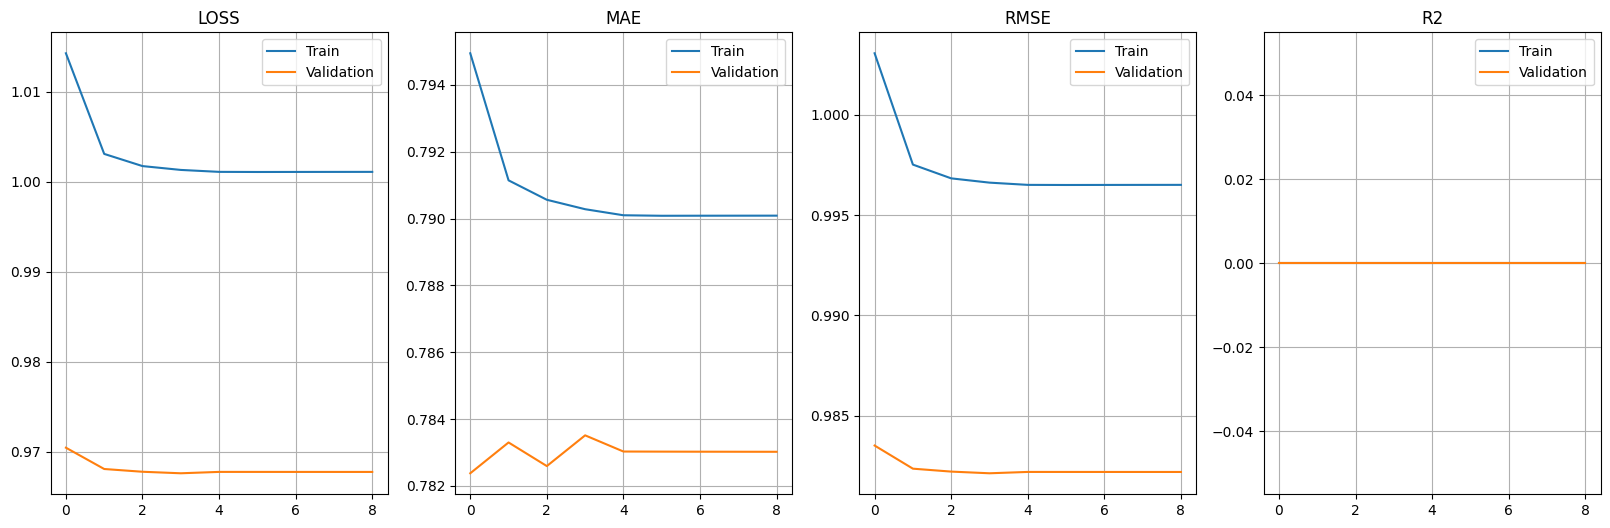

In [40]:
metrics_tracker.plot_history()

In [41]:
test_logits, test_labels = overall_functions.get_test(model, X_test, adj_test, indices_test, y_test)
metrics_tracker.get_metrics(test_logits, test_labels)

(tensor(1.0336), tensor(0.7995), tensor(1.0167), 0)

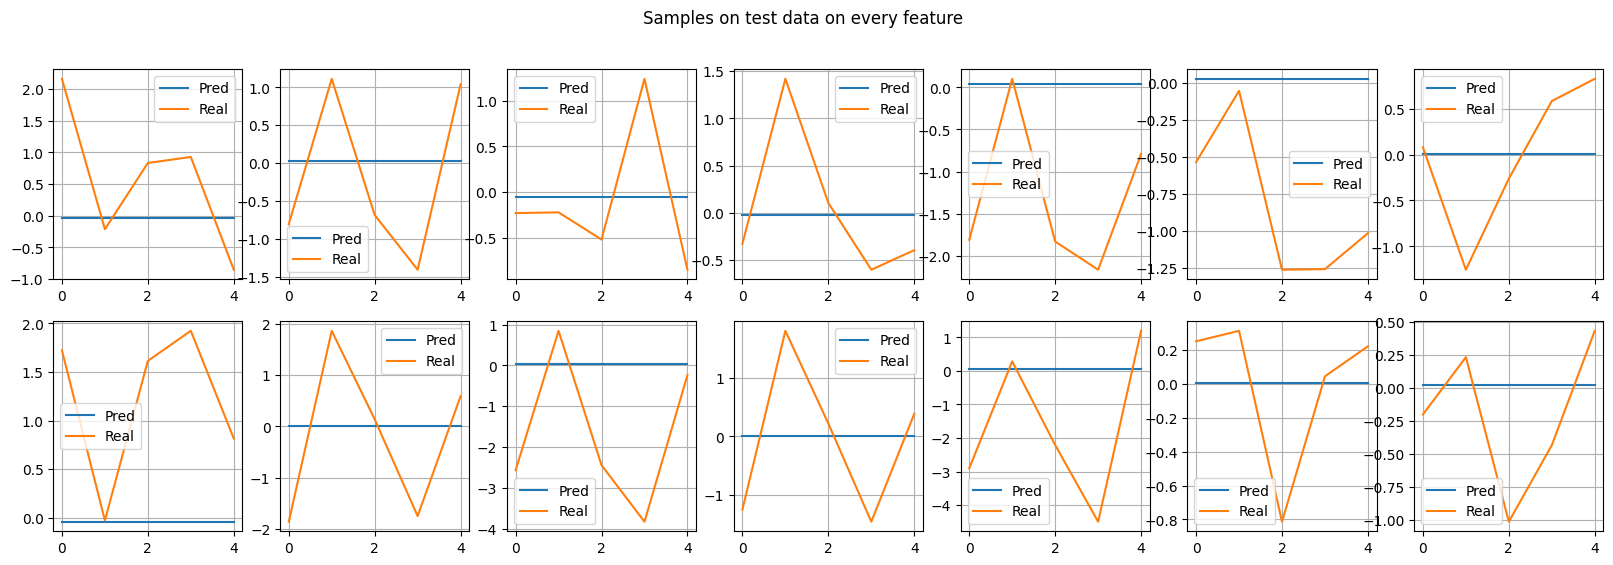

In [42]:
regression.plot_tests(test_logits, test_labels)